In [1]:
PATH_TO_CSV = "/home/mehdi/minecraft-copilot-ml/output/lightning_logs/version_0/metrics.csv"
PATH_TO_BEST_MODEL = "/home/mehdi/minecraft-copilot-ml/output/best_model.pth"

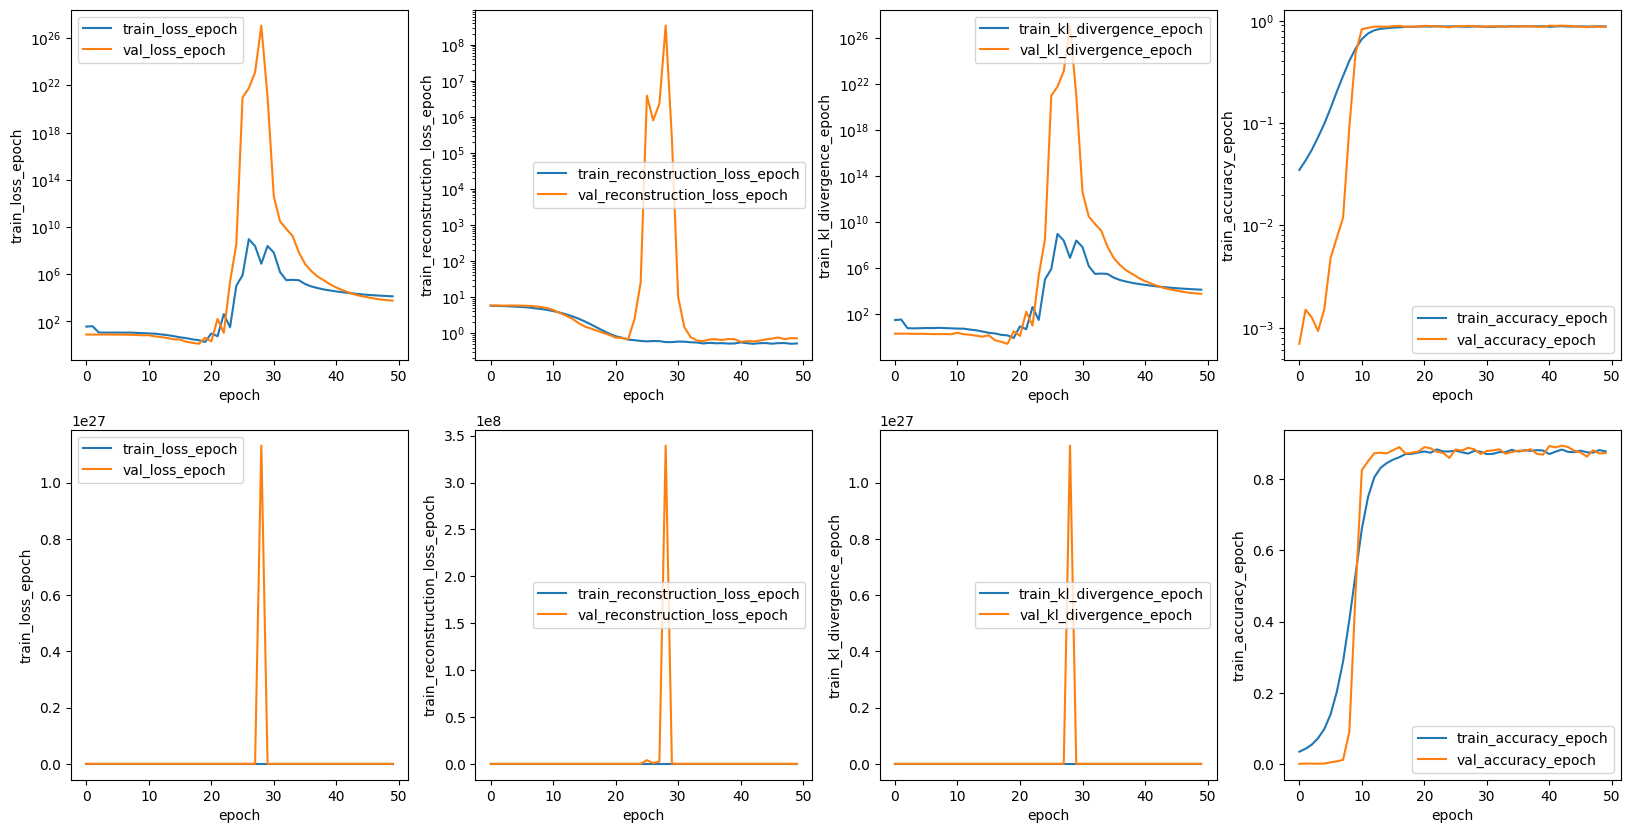

In [2]:
import os
from seaborn import lineplot
import pandas as pd

from matplotlib import pyplot as plt

metrics = ["loss", "reconstruction_loss", "kl_divergence", "accuracy"]
fig, ax = plt.subplots(2, len(metrics), figsize=(20, 10))

if os.path.exists(PATH_TO_CSV):
    df = pd.read_csv(PATH_TO_CSV)
    for i, metric in enumerate(metrics):
        lineplot(data=df, x="epoch", y=f"train_{metric}_epoch", ax=ax[0, i], label=f"train_{metric}_epoch")
        lineplot(data=df, x="epoch", y=f"val_{metric}_epoch", ax=ax[0, i], label=f"val_{metric}_epoch")
        lineplot(data=df, x="epoch", y=f"train_{metric}_epoch", ax=ax[1, i], label=f"train_{metric}_epoch")
        lineplot(data=df, x="epoch", y=f"val_{metric}_epoch", ax=ax[1, i], label=f"val_{metric}_epoch")
        ax[0, i].set(yscale="log")
        ax[1, i].set(yscale="linear")
else:
    print(f"File {PATH_TO_CSV} not found")

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from minecraft_copilot_ml.data_loader import (
    get_working_files_and_unique_blocks_and_counts,
    list_schematic_files_in_folder,
)
from minecraft_copilot_ml.train import MinecraftSchematicsDataset

schematics_list_files = list_schematic_files_in_folder("/home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset")
unique_blocks_dict, unique_counts_coefficients, loaded_schematic_files = get_working_files_and_unique_blocks_and_counts(
    schematics_list_files
)
dataset = MinecraftSchematicsDataset(loaded_schematic_files)

0it [00:00, ?it/s]

Found 2 copy 32.schematic: : 0it [00:00, ?it/s]

Found 2 copy 64.schematic: : 0it [00:00, ?it/s]

Found 2 copy 12.schematic: : 0it [00:00, ?it/s]

Found 2 copy 72.schematic: : 0it [00:00, ?it/s]

Found 2 copy 26.schematic: : 0it [00:00, ?it/s]

Found 2 copy 31.schematic: : 0it [00:00, ?it/s]

Found 2 copy 91.schematic: : 0it [00:00, ?it/s]

Found 2 copy 70.schematic: : 0it [00:00, ?it/s]

Found 2.schematic: : 0it [00:00, ?it/s]        

Found 2 copy 46.schematic: : 0it [00:00, ?it/s]

Found 2 copy 34.schematic: : 0it [00:00, ?it/s]

Found 2 copy 55.schematic: : 0it [00:00, ?it/s]

Found 2 copy 60.schematic: : 0it [00:00, ?it/s]

Found 2 copy 69.schematic: : 0it [00:00, ?it/s]

Found 2 copy 16.schematic: : 0it [00:00, ?it/s]

Found 2 copy 23.schematic: : 0it [00:00, ?it/s]

Found 2 copy 30.schematic: : 0it [00:00, ?it/s]

Found 2 copy 20.schematic: : 0it [00:00, ?it/s]

Found 2 copy 95.schematic: : 0it [00:00, ?it/s]

Found 2 copy 25.schematic: : 0it [00:00, ?it/s]

Found 2 copy 14.schematic: : 0it [00:00, ?it/s]

Found 2 copy 27.schematic: : 0it [00:00, ?it/s]

Found 2 copy 88.schematic: : 0it [00:00, ?it/s]

Found 2 copy 96.schematic: : 0it [00:00, ?it/s]

Found 2 copy 97.schematic: : 0it [00:00, ?it/s]

Found 2 copy 92.schematic: : 0it [00:00, ?it/s]

Found 2 copy 41.schematic: : 0it [00:00, ?it/s]

Found 2 copy 44.schematic: : 0it [00:00, ?it/s]

Found 2 copy 42.schematic: : 0it [00:00, ?it/s]

Found 2 copy 53.schematic: : 0it [00:00, ?it/s]

Found 2 copy 83.schematic: : 0it [00:00, ?it/s]

Found 2 copy 71.schematic: : 0it [00:00, ?it/s]

Found 2 copy 85.schematic: : 0it [00:00, ?it/s]

Found 2 copy 59.schematic: : 0it [00:00, ?it/s]

Found 2 copy 68.schematic: : 0it [00:00, ?it/s]

Found 2 copy 47.schematic: : 0it [00:00, ?it/s]

Found 2 copy 51.schematic: : 0it [00:00, ?it/s]

Found 2 copy 33.schematic: : 0it [00:00, ?it/s]

Found 2 copy 48.schematic: : 0it [00:00, ?it/s]

Found 2 copy 7.schematic: : 0it [00:00, ?it/s] 

Found 2 copy 18.schematic: : 0it [00:00, ?it/s]

Found 2 copy 28.schematic: : 0it [00:00, ?it/s]

Found 2 copy 52.schematic: : 0it [00:00, ?it/s]

Found 2 copy 77.schematic: : 0it [00:00, ?it/s]

Found 2 copy 24.schematic: : 0it [00:00, ?it/s]

Found 2 copy 10.schematic: : 0it [00:00, ?it/s]

Found 2 copy 19.schematic: : 0it [00:00, ?it/s]

Found 2 copy 45.schematic: : 0it [00:00, ?it/s]

Found 2 copy 39.schematic: : 0it [00:00, ?it/s]

Found 2 copy 65.schematic: : 0it [00:00, ?it/s]

Found 2 copy 93.schematic: : 0it [00:00, ?it/s]

Found 2 copy 13.schematic: : 0it [00:00, ?it/s]

Found 2 copy 63.schematic: : 0it [00:00, ?it/s]

Found 2 copy 15.schematic: : 0it [00:00, ?it/s]

Found 2 copy 84.schematic: : 0it [00:00, ?it/s]

Found 2 copy 54.schematic: : 0it [00:00, ?it/s]

Found 2 copy 5.schematic: : 0it [00:00, ?it/s] 

Found 2 copy 62.schematic: : 0it [00:00, ?it/s]

Found 2 copy 43.schematic: : 0it [00:00, ?it/s]

Found 2 copy 57.schematic: : 0it [00:00, ?it/s]

Found 2 copy 76.schematic: : 0it [00:00, ?it/s]

Found 2 copy 90.schematic: : 0it [00:00, ?it/s]

Found 2 copy 56.schematic: : 0it [00:00, ?it/s]

Found 2 copy 75.schematic: : 0it [00:00, ?it/s]

Found 2 copy 4.schematic: : 0it [00:00, ?it/s] 

Found 2 copy 29.schematic: : 0it [00:00, ?it/s]

Found 2 copy 49.schematic: : 0it [00:00, ?it/s]

Found 2 copy.schematic: : 0it [00:00, ?it/s]   

Found 2 copy 35.schematic: : 0it [00:00, ?it/s]

Found 2 copy 98.schematic: : 0it [00:00, ?it/s]

Found 2 copy 86.schematic: : 0it [00:00, ?it/s]

Found 2 copy 2.schematic: : 0it [00:00, ?it/s] 

Found 2 copy 8.schematic: : 0it [00:00, ?it/s]

Found 2 copy 22.schematic: : 0it [00:00, ?it/s]

Found 2 copy 74.schematic: : 0it [00:00, ?it/s]

Found 2 copy 87.schematic: : 0it [00:00, ?it/s]

Found 2 copy 61.schematic: : 0it [00:00, ?it/s]

Found 2 copy 38.schematic: : 0it [00:00, ?it/s]

Found 2 copy 9.schematic: : 0it [00:00, ?it/s] 

Found 2 copy 94.schematic: : 0it [00:00, ?it/s]

Found 2 copy 80.schematic: : 0it [00:00, ?it/s]

Found 2 copy 81.schematic: : 0it [00:00, ?it/s]

Found 2 copy 40.schematic: : 0it [00:00, ?it/s]

Found 2 copy 17.schematic: : 0it [00:00, ?it/s]

Found 2 copy 36.schematic: : 0it [00:00, ?it/s]

Found 2 copy 11.schematic: : 0it [00:00, ?it/s]

Found 2 copy 79.schematic: : 0it [00:00, ?it/s]

Found 2 copy 58.schematic: : 0it [00:00, ?it/s]

Found 2 copy 21.schematic: : 0it [00:00, ?it/s]

Found 2 copy 89.schematic: : 0it [00:00, ?it/s]

Found 2 copy 66.schematic: : 0it [00:00, ?it/s]

Found 2 copy 99.schematic: : 0it [00:00, ?it/s]

Found 2 copy 37.schematic: : 0it [00:00, ?it/s]

Found 2 copy 82.schematic: : 0it [00:00, ?it/s]

Found 2 copy 67.schematic: : 0it [00:00, ?it/s]

Found 2 copy 3.schematic: : 0it [00:00, ?it/s] 

Found 2 copy 6.schematic: : 0it [00:00, ?it/s]

Found 2 copy 78.schematic: : 0it [00:00, ?it/s]

Found 2 copy 73.schematic: : 0it [00:00, ?it/s]

Found 2 copy 50.schematic: : 0it [00:00, ?it/s]

Found 2 copy 50.schematic: : 1it [00:00, 11.82it/s]


2024-02-18 18:24:46.259 | INFO     | minecraft_copilot_ml.data_loader:list_schematic_files_in_folder:177 - Found 100 schematics files.


  0%|                                                                                                                                                                                    | 0/100 [00:00<?, ?it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 32.schematic:   0%|                                                                                     | 0/100 [00:00<?, ?it/s]

2024-02-18 18:24:46.375 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:air


2024-02-18 18:24:46.377 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:cobblestone


2024-02-18 18:24:46.378 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:dirt


2024-02-18 18:24:46.379 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:enchanting_table


2024-02-18 18:24:46.381 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:glass


2024-02-18 18:24:46.382 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:grass


2024-02-18 18:24:46.384 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:gravel


2024-02-18 18:24:46.386 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:ladder


2024-02-18 18:24:46.387 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:nether_brick_fence


2024-02-18 18:24:46.388 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:oak_stairs


2024-02-18 18:24:46.389 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:obsidian


2024-02-18 18:24:46.390 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:redstone_torch


2024-02-18 18:24:46.392 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:stone_brick_stairs


2024-02-18 18:24:46.393 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:stone_slab


2024-02-18 18:24:46.394 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:stone_stairs


2024-02-18 18:24:46.396 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:stonebrick


2024-02-18 18:24:46.397 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:torch


2024-02-18 18:24:46.399 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:trapdoor


2024-02-18 18:24:46.400 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:wall_sign


2024-02-18 18:24:46.401 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:wood


2024-02-18 18:24:46.402 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:wooden_door


Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 32.schematic:   1%|▊                                                                            | 1/100 [00:00<00:13,  7.32it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 64.schematic:   1%|▊                                                                            | 1/100 [00:00<00:13,  7.27it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 64.schematic:   2%|█▌                                                                           | 2/100 [00:00<00:12,  8.09it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 12.schematic:   2%|█▌                                                                           | 2/100 [00:00<00:12,  8.06it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 12.schematic:   3%|██▎                                                                          | 3/100 [00:00<00:11,  8.48it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 72.schematic:   3%|██▎                                                                          | 3/100 [00:00<00:11,  8.46it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 72.schematic:   4%|███                                                                          | 4/100 [00:00<00:11,  8.64it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 26.schematic:   4%|███                                                                          | 4/100 [00:00<00:11,  8.63it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 26.schematic:   5%|███▊                                                                         | 5/100 [00:00<00:10,  8.84it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 31.schematic:   5%|███▊                                                                         | 5/100 [00:00<00:10,  8.83it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 31.schematic:   6%|████▌                                                                        | 6/100 [00:00<00:10,  8.90it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 91.schematic:   6%|████▌                                                                        | 6/100 [00:00<00:10,  8.89it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 91.schematic:   7%|█████▍                                                                       | 7/100 [00:00<00:10,  8.94it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 70.schematic:   7%|█████▍                                                                       | 7/100 [00:00<00:10,  8.93it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 70.schematic:   8%|██████▏                                                                      | 8/100 [00:00<00:10,  8.96it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2.schematic:   8%|██████▊                                                                              | 8/100 [00:00<00:10,  8.95it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2.schematic:   9%|███████▋                                                                             | 9/100 [00:01<00:10,  8.99it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 46.schematic:   9%|██████▉                                                                      | 9/100 [00:01<00:10,  8.98it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 46.schematic:  10%|███████▌                                                                    | 10/100 [00:01<00:09,  9.02it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 34.schematic:  10%|███████▌                                                                    | 10/100 [00:01<00:09,  9.01it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 34.schematic:  11%|████████▎                                                                   | 11/100 [00:01<00:09,  9.04it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 55.schematic:  11%|████████▎                                                                   | 11/100 [00:01<00:09,  9.03it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 55.schematic:  12%|█████████                                                                   | 12/100 [00:01<00:09,  9.06it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 60.schematic:  12%|█████████                                                                   | 12/100 [00:01<00:09,  9.05it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 60.schematic:  13%|█████████▉                                                                  | 13/100 [00:01<00:09,  9.06it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 69.schematic:  13%|█████████▉                                                                  | 13/100 [00:01<00:09,  9.06it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 69.schematic:  14%|██████████▋                                                                 | 14/100 [00:01<00:09,  9.11it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 16.schematic:  14%|██████████▋                                                                 | 14/100 [00:01<00:09,  9.10it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 16.schematic:  15%|███████████▍                                                                | 15/100 [00:01<00:09,  9.11it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 23.schematic:  15%|███████████▍                                                                | 15/100 [00:01<00:09,  9.11it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 23.schematic:  16%|████████████▏                                                               | 16/100 [00:01<00:09,  9.13it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 30.schematic:  16%|████████████▏                                                               | 16/100 [00:01<00:09,  9.12it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 30.schematic:  17%|████████████▉                                                               | 17/100 [00:01<00:09,  9.14it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 20.schematic:  17%|████████████▉                                                               | 17/100 [00:01<00:09,  9.13it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 20.schematic:  18%|█████████████▋                                                              | 18/100 [00:01<00:08,  9.14it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 95.schematic:  18%|█████████████▋                                                              | 18/100 [00:01<00:08,  9.14it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 95.schematic:  19%|██████████████▍                                                             | 19/100 [00:02<00:08,  9.15it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 25.schematic:  19%|██████████████▍                                                             | 19/100 [00:02<00:08,  9.14it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 25.schematic:  20%|███████████████▏                                                            | 20/100 [00:02<00:08,  9.12it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 14.schematic:  20%|███████████████▏                                                            | 20/100 [00:02<00:08,  9.11it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 14.schematic:  21%|███████████████▉                                                            | 21/100 [00:02<00:08,  9.14it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 27.schematic:  21%|███████████████▉                                                            | 21/100 [00:02<00:08,  9.14it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 27.schematic:  22%|████████████████▋                                                           | 22/100 [00:02<00:08,  9.15it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 88.schematic:  22%|████████████████▋                                                           | 22/100 [00:02<00:08,  9.15it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 88.schematic:  23%|█████████████████▍                                                          | 23/100 [00:02<00:08,  9.15it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 96.schematic:  23%|█████████████████▍                                                          | 23/100 [00:02<00:08,  9.15it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 96.schematic:  24%|██████████████████▏                                                         | 24/100 [00:02<00:08,  9.16it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 97.schematic:  24%|██████████████████▏                                                         | 24/100 [00:02<00:08,  9.16it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 97.schematic:  25%|███████████████████                                                         | 25/100 [00:02<00:08,  9.16it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 92.schematic:  25%|███████████████████                                                         | 25/100 [00:02<00:08,  9.16it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 92.schematic:  26%|███████████████████▊                                                        | 26/100 [00:02<00:08,  9.17it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 41.schematic:  26%|███████████████████▊                                                        | 26/100 [00:02<00:08,  9.17it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 41.schematic:  27%|████████████████████▌                                                       | 27/100 [00:02<00:07,  9.17it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 44.schematic:  27%|████████████████████▌                                                       | 27/100 [00:02<00:07,  9.17it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 44.schematic:  28%|█████████████████████▎                                                      | 28/100 [00:03<00:07,  9.18it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 42.schematic:  28%|█████████████████████▎                                                      | 28/100 [00:03<00:07,  9.17it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 42.schematic:  29%|██████████████████████                                                      | 29/100 [00:03<00:07,  9.19it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 53.schematic:  29%|██████████████████████                                                      | 29/100 [00:03<00:07,  9.18it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 53.schematic:  30%|██████████████████████▊                                                     | 30/100 [00:03<00:07,  9.19it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 83.schematic:  30%|██████████████████████▊                                                     | 30/100 [00:03<00:07,  9.19it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 83.schematic:  31%|███████████████████████▌                                                    | 31/100 [00:03<00:07,  9.20it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 71.schematic:  31%|███████████████████████▌                                                    | 31/100 [00:03<00:07,  9.19it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 71.schematic:  32%|████████████████████████▎                                                   | 32/100 [00:03<00:07,  9.20it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 85.schematic:  32%|████████████████████████▎                                                   | 32/100 [00:03<00:07,  9.20it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 85.schematic:  33%|█████████████████████████                                                   | 33/100 [00:03<00:07,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 59.schematic:  33%|█████████████████████████                                                   | 33/100 [00:03<00:07,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 59.schematic:  34%|█████████████████████████▊                                                  | 34/100 [00:03<00:07,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 68.schematic:  34%|█████████████████████████▊                                                  | 34/100 [00:03<00:07,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 68.schematic:  35%|██████████████████████████▌                                                 | 35/100 [00:03<00:07,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 47.schematic:  35%|██████████████████████████▌                                                 | 35/100 [00:03<00:07,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 47.schematic:  36%|███████████████████████████▎                                                | 36/100 [00:03<00:06,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 51.schematic:  36%|███████████████████████████▎                                                | 36/100 [00:03<00:06,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 51.schematic:  37%|████████████████████████████                                                | 37/100 [00:04<00:06,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 33.schematic:  37%|████████████████████████████                                                | 37/100 [00:04<00:06,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 33.schematic:  38%|████████████████████████████▉                                               | 38/100 [00:04<00:06,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 48.schematic:  38%|████████████████████████████▉                                               | 38/100 [00:04<00:06,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 48.schematic:  39%|█████████████████████████████▋                                              | 39/100 [00:04<00:06,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 7.schematic:  39%|██████████████████████████████                                               | 39/100 [00:04<00:06,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 7.schematic:  40%|██████████████████████████████▊                                              | 40/100 [00:04<00:06,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 18.schematic:  40%|██████████████████████████████▍                                             | 40/100 [00:04<00:06,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 18.schematic:  41%|███████████████████████████████▏                                            | 41/100 [00:04<00:06,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 28.schematic:  41%|███████████████████████████████▏                                            | 41/100 [00:04<00:06,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 28.schematic:  42%|███████████████████████████████▉                                            | 42/100 [00:04<00:06,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 52.schematic:  42%|███████████████████████████████▉                                            | 42/100 [00:04<00:06,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 52.schematic:  43%|████████████████████████████████▋                                           | 43/100 [00:04<00:06,  9.20it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 77.schematic:  43%|████████████████████████████████▋                                           | 43/100 [00:04<00:06,  9.20it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 77.schematic:  44%|█████████████████████████████████▍                                          | 44/100 [00:04<00:06,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 24.schematic:  44%|█████████████████████████████████▍                                          | 44/100 [00:04<00:06,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 24.schematic:  45%|██████████████████████████████████▏                                         | 45/100 [00:04<00:05,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 10.schematic:  45%|██████████████████████████████████▏                                         | 45/100 [00:04<00:05,  9.20it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 10.schematic:  46%|██████████████████████████████████▉                                         | 46/100 [00:04<00:05,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 19.schematic:  46%|██████████████████████████████████▉                                         | 46/100 [00:04<00:05,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 19.schematic:  47%|███████████████████████████████████▋                                        | 47/100 [00:05<00:05,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 45.schematic:  47%|███████████████████████████████████▋                                        | 47/100 [00:05<00:05,  9.21it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 45.schematic:  48%|████████████████████████████████████▍                                       | 48/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 39.schematic:  48%|████████████████████████████████████▍                                       | 48/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 39.schematic:  49%|█████████████████████████████████████▏                                      | 49/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 65.schematic:  49%|█████████████████████████████████████▏                                      | 49/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 65.schematic:  50%|██████████████████████████████████████                                      | 50/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 93.schematic:  50%|██████████████████████████████████████                                      | 50/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 93.schematic:  51%|██████████████████████████████████████▊                                     | 51/100 [00:05<00:05,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 13.schematic:  51%|██████████████████████████████████████▊                                     | 51/100 [00:05<00:05,  9.22it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 13.schematic:  52%|███████████████████████████████████████▌                                    | 52/100 [00:05<00:05,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 63.schematic:  52%|███████████████████████████████████████▌                                    | 52/100 [00:05<00:05,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 63.schematic:  53%|████████████████████████████████████████▎                                   | 53/100 [00:05<00:05,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 15.schematic:  53%|████████████████████████████████████████▎                                   | 53/100 [00:05<00:05,  9.23it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 15.schematic:  54%|█████████████████████████████████████████                                   | 54/100 [00:05<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 84.schematic:  54%|█████████████████████████████████████████                                   | 54/100 [00:05<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 84.schematic:  55%|█████████████████████████████████████████▊                                  | 55/100 [00:05<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 54.schematic:  55%|█████████████████████████████████████████▊                                  | 55/100 [00:05<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 54.schematic:  56%|██████████████████████████████████████████▌                                 | 56/100 [00:06<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 5.schematic:  56%|███████████████████████████████████████████                                  | 56/100 [00:06<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 5.schematic:  57%|███████████████████████████████████████████▉                                 | 57/100 [00:06<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 62.schematic:  57%|███████████████████████████████████████████▎                                | 57/100 [00:06<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 62.schematic:  58%|████████████████████████████████████████████                                | 58/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 43.schematic:  58%|████████████████████████████████████████████                                | 58/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 43.schematic:  59%|████████████████████████████████████████████▊                               | 59/100 [00:06<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 57.schematic:  59%|████████████████████████████████████████████▊                               | 59/100 [00:06<00:04,  9.24it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 57.schematic:  60%|█████████████████████████████████████████████▌                              | 60/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 76.schematic:  60%|█████████████████████████████████████████████▌                              | 60/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 76.schematic:  61%|██████████████████████████████████████████████▎                             | 61/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 90.schematic:  61%|██████████████████████████████████████████████▎                             | 61/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 90.schematic:  62%|███████████████████████████████████████████████                             | 62/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 56.schematic:  62%|███████████████████████████████████████████████                             | 62/100 [00:06<00:04,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 56.schematic:  63%|███████████████████████████████████████████████▉                            | 63/100 [00:06<00:03,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 75.schematic:  63%|███████████████████████████████████████████████▉                            | 63/100 [00:06<00:03,  9.25it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 75.schematic:  64%|████████████████████████████████████████████████▋                           | 64/100 [00:06<00:03,  9.26it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 4.schematic:  64%|█████████████████████████████████████████████████▎                           | 64/100 [00:06<00:03,  9.26it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 4.schematic:  65%|██████████████████████████████████████████████████                           | 65/100 [00:07<00:03,  9.26it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 29.schematic:  65%|█████████████████████████████████████████████████▍                          | 65/100 [00:07<00:03,  9.26it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 29.schematic:  66%|██████████████████████████████████████████████████▏                         | 66/100 [00:07<00:03,  9.27it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 49.schematic:  66%|██████████████████████████████████████████████████▏                         | 66/100 [00:07<00:03,  9.26it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 49.schematic:  67%|██████████████████████████████████████████████████▉                         | 67/100 [00:07<00:03,  9.27it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy.schematic:  67%|████████████████████████████████████████████████████▉                          | 67/100 [00:07<00:03,  9.27it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy.schematic:  68%|█████████████████████████████████████████████████████▋                         | 68/100 [00:07<00:03,  9.27it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 35.schematic:  68%|███████████████████████████████████████████████████▋                        | 68/100 [00:07<00:03,  9.27it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 35.schematic:  69%|████████████████████████████████████████████████████▍                       | 69/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 98.schematic:  69%|████████████████████████████████████████████████████▍                       | 69/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 98.schematic:  70%|█████████████████████████████████████████████████████▏                      | 70/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 86.schematic:  70%|█████████████████████████████████████████████████████▏                      | 70/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 86.schematic:  71%|█████████████████████████████████████████████████████▉                      | 71/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 2.schematic:  71%|██████████████████████████████████████████████████████▋                      | 71/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 2.schematic:  72%|███████████████████████████████████████████████████████▍                     | 72/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 8.schematic:  72%|███████████████████████████████████████████████████████▍                     | 72/100 [00:07<00:03,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 8.schematic:  73%|████████████████████████████████████████████████████████▏                    | 73/100 [00:07<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 22.schematic:  73%|███████████████████████████████████████████████████████▍                    | 73/100 [00:07<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 22.schematic:  74%|████████████████████████████████████████████████████████▏                   | 74/100 [00:07<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 74.schematic:  74%|████████████████████████████████████████████████████████▏                   | 74/100 [00:07<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 74.schematic:  75%|█████████████████████████████████████████████████████████                   | 75/100 [00:08<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 87.schematic:  75%|█████████████████████████████████████████████████████████                   | 75/100 [00:08<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 87.schematic:  76%|█████████████████████████████████████████████████████████▊                  | 76/100 [00:08<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 61.schematic:  76%|█████████████████████████████████████████████████████████▊                  | 76/100 [00:08<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 61.schematic:  77%|██████████████████████████████████████████████████████████▌                 | 77/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 38.schematic:  77%|██████████████████████████████████████████████████████████▌                 | 77/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 38.schematic:  78%|███████████████████████████████████████████████████████████▎                | 78/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 9.schematic:  78%|████████████████████████████████████████████████████████████                 | 78/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 9.schematic:  79%|████████████████████████████████████████████████████████████▊                | 79/100 [00:08<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 94.schematic:  79%|████████████████████████████████████████████████████████████                | 79/100 [00:08<00:02,  9.28it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 94.schematic:  80%|████████████████████████████████████████████████████████████▊               | 80/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 80.schematic:  80%|████████████████████████████████████████████████████████████▊               | 80/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 80.schematic:  81%|█████████████████████████████████████████████████████████████▌              | 81/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 81.schematic:  81%|█████████████████████████████████████████████████████████████▌              | 81/100 [00:08<00:02,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 81.schematic:  82%|██████████████████████████████████████████████████████████████▎             | 82/100 [00:08<00:01,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 40.schematic:  82%|██████████████████████████████████████████████████████████████▎             | 82/100 [00:08<00:01,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 40.schematic:  83%|███████████████████████████████████████████████████████████████             | 83/100 [00:08<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 17.schematic:  83%|███████████████████████████████████████████████████████████████             | 83/100 [00:08<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 17.schematic:  84%|███████████████████████████████████████████████████████████████▊            | 84/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 36.schematic:  84%|███████████████████████████████████████████████████████████████▊            | 84/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 36.schematic:  85%|████████████████████████████████████████████████████████████████▌           | 85/100 [00:09<00:01,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 11.schematic:  85%|████████████████████████████████████████████████████████████████▌           | 85/100 [00:09<00:01,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 11.schematic:  86%|█████████████████████████████████████████████████████████████████▎          | 86/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 79.schematic:  86%|█████████████████████████████████████████████████████████████████▎          | 86/100 [00:09<00:01,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 79.schematic:  87%|██████████████████████████████████████████████████████████████████          | 87/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 58.schematic:  87%|██████████████████████████████████████████████████████████████████          | 87/100 [00:09<00:01,  9.29it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 58.schematic:  88%|██████████████████████████████████████████████████████████████████▉         | 88/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 21.schematic:  88%|██████████████████████████████████████████████████████████████████▉         | 88/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 21.schematic:  89%|███████████████████████████████████████████████████████████████████▋        | 89/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 89.schematic:  89%|███████████████████████████████████████████████████████████████████▋        | 89/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 89.schematic:  90%|████████████████████████████████████████████████████████████████████▍       | 90/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 66.schematic:  90%|████████████████████████████████████████████████████████████████████▍       | 90/100 [00:09<00:01,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 66.schematic:  91%|█████████████████████████████████████████████████████████████████████▏      | 91/100 [00:09<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 99.schematic:  91%|█████████████████████████████████████████████████████████████████████▏      | 91/100 [00:09<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 99.schematic:  92%|█████████████████████████████████████████████████████████████████████▉      | 92/100 [00:09<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 37.schematic:  92%|█████████████████████████████████████████████████████████████████████▉      | 92/100 [00:09<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 37.schematic:  93%|██████████████████████████████████████████████████████████████████████▋     | 93/100 [00:09<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 82.schematic:  93%|██████████████████████████████████████████████████████████████████████▋     | 93/100 [00:09<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 82.schematic:  94%|███████████████████████████████████████████████████████████████████████▍    | 94/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 67.schematic:  94%|███████████████████████████████████████████████████████████████████████▍    | 94/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 67.schematic:  95%|████████████████████████████████████████████████████████████████████████▏   | 95/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 3.schematic:  95%|█████████████████████████████████████████████████████████████████████████▏   | 95/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 3.schematic:  96%|█████████████████████████████████████████████████████████████████████████▉   | 96/100 [00:10<00:00,  9.31it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 6.schematic:  96%|█████████████████████████████████████████████████████████████████████████▉   | 96/100 [00:10<00:00,  9.31it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 6.schematic:  97%|██████████████████████████████████████████████████████████████████████████▋  | 97/100 [00:10<00:00,  9.31it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 78.schematic:  97%|█████████████████████████████████████████████████████████████████████████▋  | 97/100 [00:10<00:00,  9.31it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 78.schematic:  98%|██████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 73.schematic:  98%|██████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 73.schematic:  99%|███████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 50.schematic:  99%|███████████████████████████████████████████████████████████████████████████▏| 99/100 [00:10<00:00,  9.30it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 50.schematic: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]

Processing /home/mehdi/minecraft-copilot-ml/datasets/small_chapel_dataset/2 copy 50.schematic: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]

/tmp/ipykernel_2792/2603576988.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_palette = cm.get_cmap("tab10").colors


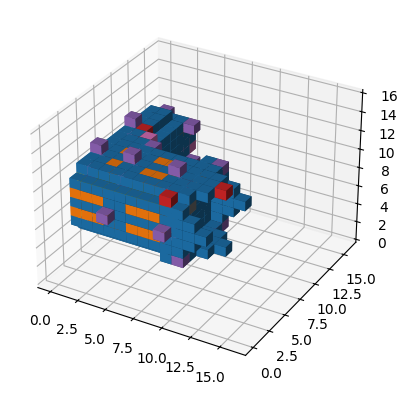

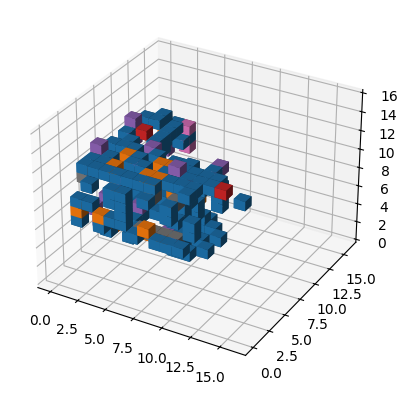

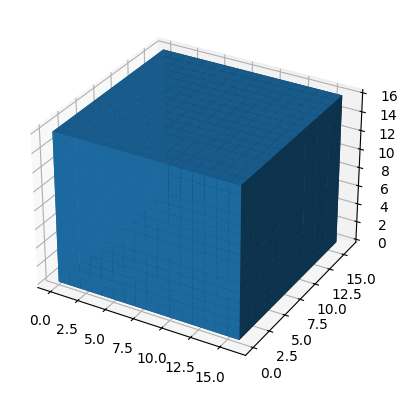

In [4]:
from typing import Any
import matplotlib.cm as cm
colors_palette = cm.get_cmap("tab10").colors
block_map, noisy_block_map, mask = dataset[0]
# map_vectorizeds = np.vectorize(lambda x: unique_blocks_dict[x])(mask)

def display_voxels(voxel: np.ndarray, zero_block: Any = 0):
    ax = plt.figure().add_subplot(projection="3d")
    unique_values = set(np.unique(voxel))
    
    colors = np.empty(voxel.shape, dtype=object)
    for i, value in enumerate(unique_values):
        colors[voxel == value] = {colors_palette[i % len(colors_palette)]}
    ax.voxels(voxel != zero_block, facecolors=colors)
    plt.show()

display_voxels(block_map, zero_block="minecraft:air")
display_voxels(noisy_block_map, zero_block="minecraft:air")
display_voxels(mask, zero_block=0)

In [5]:
import torch
import torch.nn.functional as F

model = torch.load(PATH_TO_BEST_MODEL)

pre_processed_noisy_block_map = model.pre_process(np.expand_dims(noisy_block_map, axis=0)).unsqueeze(0).float()
reconstruction, mean, log_variance = model(pre_processed_noisy_block_map)
post_processed_filled_block_map = model.post_process(reconstruction.to("cpu"))
squeezed_post_processed = post_processed_filled_block_map[0]

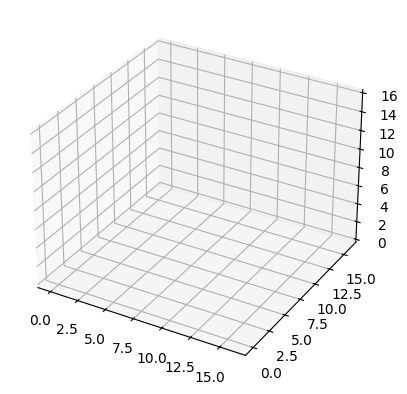

In [6]:
display_voxels(squeezed_post_processed, zero_block="minecraft:air")

In [7]:
squeezed_post_processed

array([[['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air'],
        ['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air'],
        ['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air'],
        ...,
        ['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air'],
        ['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air'],
        ['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air']],

       [['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:air', 'minecraft:air'],
        ['minecraft:air', 'minecraft:air', 'minecraft:air', ...,
         'minecraft:air', 'minecraft:a